In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import locale
from custom.watermarks import add_watermark
from custom.plots import aggiorna_ascissa

# Set locale to "it" to parse the month correctly
locale.setlocale(locale.LC_ALL, "it_IT.UTF-8")
# plt.style.use('default')
plt.style.use('seaborn-dark')

### Importa dati sulle vaccinazioni

In [2]:
df_vacc = pd.read_csv('https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/vaccinations/vaccinations.csv')
df_vacc = df_vacc.fillna(method='backfill')

### Importa dati epidemiologici

In [3]:
file_confirmed='https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
file_deaths='https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
file_recovered='https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv'
df_confirmed=pd.read_csv(file_confirmed)
df_deaths=pd.read_csv(file_deaths)
df_recovered=pd.read_csv(file_recovered)
date = pd.to_datetime(df_confirmed.columns[4:])

### Funzioni per recuperare i dati per paese

In [4]:
def get_vaccine_data(country):
    # source ourworldindata
    
    df_vacc_country = df_vacc[df_vacc['location']==country].iloc[2:,:]
    
    date = pd.to_datetime(df_vacc_country['date'])
    vacc1 = np.array(df_vacc_country['people_vaccinated_per_hundred'])  
    vacc2 = np.array(df_vacc_country['people_fully_vaccinated_per_hundred']) 
    
    df_vacc_new = pd.DataFrame(np.transpose([vacc1,vacc2]))
    df_vacc_new.index = date
    df_vacc_new.columns=['% vaccinated with 1 dose','% fully vaccinated']
    
    return df_vacc_new

def get_epidemic_data(country):
    # source Johns Hopkins Unversity
    ydata_cases = (df_confirmed[df_confirmed['Country/Region']==country].iloc[:,4:]).sum()
    ydata_deaths = (df_deaths[df_deaths['Country/Region']==country].iloc[:,4:]).sum()
    ydata_rec = (df_recovered[df_recovered['Country/Region']==country].iloc[:,4:]).sum()
    ydata_inf = ydata_cases-ydata_deaths-ydata_rec   
    daily_cases = ydata_cases.diff().rolling(window=7).mean()
    daily_deaths = ydata_deaths.diff().rolling(window=7).mean()
    
    df_epidemic = pd.DataFrame(np.transpose([ydata_cases, ydata_inf, ydata_deaths,
                                             ydata_rec, daily_cases, daily_deaths]))
    df_epidemic.index = date
    df_epidemic.columns = ['Total cases','Active infected','Total deaths','Total recovered','Daily cases (avg 7 days)','Daily deaths (avg 7 days)']
    
    return df_epidemic


### Risultati

In [5]:
nomi_nazioni = ['Bulgaria', 'Romania', 'Portugal']
label_nazioni = ['Bulgaria', 'Romania', 'Portogallo']
abitanti_nazioni = [6.883, 19.29, 10.159]

watermark fontsize: 15, angle:-26.57


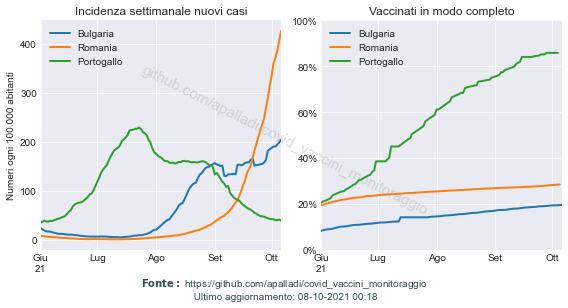

In [6]:
x_date = ['2021-06-01', '2021-07-01', '2021-08-01', '2021-09-01', '2021-10-01']
x_label = ['Giu\n21', 'Lug', 'Ago', 'Set', 'Ott']
fig, axes2 = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))

# unpack all the axes subplots
axes = axes2.ravel()

last_updated = pd.to_datetime(x_date[-1])

for i in range(len(nomi_nazioni)):
    df_epid = get_epidemic_data(nomi_nazioni[i])
    new_date = df_epid.index[-1]    
    mask = df_epid.index >= '2021-06-01'
    values = 7/(abitanti_nazioni[i]*10)*df_epid['Daily cases (avg 7 days)'][mask]
    values.plot(ax=axes[0], label=label_nazioni[i], linewidth=2)

    last_updated = aggiorna_ascissa(new_date, last_updated)
    

axes[0].set_xlim('2021-06-01', last_updated)
axes[0].set_title('Incidenza settimanale nuovi casi')
axes[0].set_ylabel('Numeri ogni 100.000 abitanti')
axes[0].set_xlabel('')
axes[0].set_xticks(x_date)
axes[0].set_xticklabels(x_label)
axes[0].legend()
axes[0].grid()
axes[0].minorticks_off()

for i in range(len(nomi_nazioni)):
    df_vac = get_vaccine_data(nomi_nazioni[i])
    new_date = df_vac.index[-1]
    mask = df_vac.index >= '2021-06-01'
    df_vac['% fully vaccinated'][mask].plot(ax=axes[1], label=label_nazioni[i], linewidth=2)
    last_updated = aggiorna_ascissa(new_date, last_updated)

axes[1].set_xlim('2021-06-01', last_updated)
axes[1].set_ylim(0, 100)
axes[1].set_yticks(np.arange(0, 101, 20))
axes[1].set_yticklabels(['0%', '20%', '40%', '60%', '80%', '100%'])
axes[1].set_title('Vaccinati in modo completo')
axes[1].set_xlabel('')
axes[1].set_xticks(x_date)
axes[1].set_xticklabels(x_label),
axes[1].legend()
axes[1].grid()
axes[1].minorticks_off()

# add watermarks
ax = plt.gca()
add_watermark(fig, ax.xaxis.label.get_fontsize())

plt.tight_layout()
plt.savefig('../risultati/confronto_nazioni_epidemia-vaccino.png', dpi=300, bbox_inches="tight")
plt.show()